# Modeling Polio Infections and Deaths with Hypothetical Vaccination Dates

Project 1 

Katie B. & Michael R.


In [156]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *

# import read_csv to import data
from pandas import read_csv

# Question: How would changing the polio vaccine date change the number of polio-related deaths?
We want

In [113]:
# Load our data as a table
filename = '../../Project 1/Polio Data.csv'
table = read_csv(filename, header=0, index_col=0, decimal='.')
len(table)
table.columns = ['polios', 'census']
# Show the first five rows of the imported data
table.head()

,polios,census
Year,,
1910,3043,92000000
1911,0,93343578
1912,574,94706778
1913,0,96089886
1914,0,97493193


In [114]:
def plot_results(series1,series1_label, series2, series2_label, title, x_label, y_label):
    """Plot two timeseries.
    
    series1: First timeSeries to plot
    series2: Second timeSeries to plot
    title: string
    """
    if len(series1):
        plot(series1, ':', label=series1_label)
    if len(series2):
        plot(series2, color='gray', label=series2_label)
    
    decorate(xlabel=x_label, 
             ylabel=y_label,
             title=title)

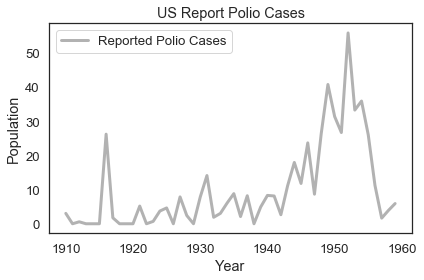

In [115]:
empty = TimeSeries()
actual = table.polios / 1e3
plot_results(empty,'Empty', actual, 'Reported Polio Cases', 'US Report Polio Cases', 'Year','Population')

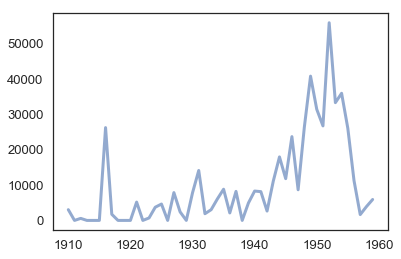

In [116]:
plot(table.polios)

In [117]:
# Define initial conditions for all systems
# Start year
t_0 = get_first_label(census)
# End year
t_end = get_last_label(census)
# Init state containing the above, assuming no polio infections or deaths yet
init = State(model_infected=0, p_dead_polios=0,actual_infected=0)

,values
model_infected,0
p_dead_polios,0
actual_infected,0


In [118]:
system = System(polio_growth = 10286,
                t_0 = t_0,
                t_end = t_end,
                model_infected_0 = 0,
                p_dead_polios = 0,
                init=init)

,values
polio_growth,10286
t_0,1910
t_end,1959
model_infected_0,0
p_dead_polios,0
init,model_infected 0 p_dead_polios 0 actu...


# Linear Growth
To begin, we assume the rate at which polio spreads is a constant 10,286 cases per year and that 15% die, leaving 85% remaining.
The control data, which does not account for deaths, is also summed here


In [119]:
def update_func1(state, t, system):
    """Update function for constant infection rate. 
    
    state: state object
    t: year
    system: system object
        
    returns: state object
    """
    
    state.model_infected += system.polio_growth
    
    state.actual_infected += table.polios[t]
    
    return State(model_infected=state.model_infected,actual_infected=state.actual_infected)

We use run simulation to simulate each year as it passes, recording the number of infected as we go and giving the output as a DataFrame object

In [141]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = DataFrame()
    results.index.write = table.index
    state = system.init
    results[system.t_0] = State(model_infected=0,actual_infected=0,polio_deaths=0)
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(state, t, system)
        
    return results

In [121]:
# Run the simulation (transpose the results so the index is first column, not first row)
results = run_simulation(system, update_func1).T;

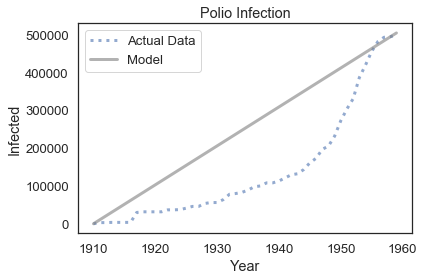

In [122]:
# Plot the results
plot_results(results.actual_infected, 'Actual Data',results.model_infected,'Model', 'Polio Infection','Year','Infected')

Here, the linear model starts and ends in the same place, but it does not line up well anywhere else.
Also, neither of these plots account for the death rate of the disease, so we need a new update function that does account for this. 

# Accounting for death

Below is our new update function which is the same to the first, except that now we account for deaths by assuming 15% of the infected die every year for both the linear model and real world data.

In [123]:
def update_func2(state, t, system):
    """Update function for constant infection rate, but accounting for deaths 
    
    state: state object
    t: year
    system: system object
        
    returns: state object
    """
    
    # Add this year's cases to the running total, then account for deaths
    state.actual_infected += table.polios[t]
    state.actual_infected *= 0.85
    
    # Calculate the spread of polio, the resulting deaths, and who is left
    state.model_infected += system.polio_growth
    state.p_dead_polios += state.model_infected * 0.15
    state.model_infected *= 0.85
    
    return State(model_infected=state.model_infected,actual_infected=state.actual_infected)

In [124]:
# Init state containing the above, assuming no polio infections or deaths yet
init = State(model_infected=0, p_dead_polios=0,actual_infected=0)
system = System(polio_growth = 10286,
                t_0 = t_0,
                t_end = t_end,
                model_infected_0 = 0,
                p_dead_polios = 0,
                init=init)

,values
polio_growth,10286
t_0,1910
t_end,1959
model_infected_0,0
p_dead_polios,0
init,model_infected 0 p_dead_polios 0 actu...


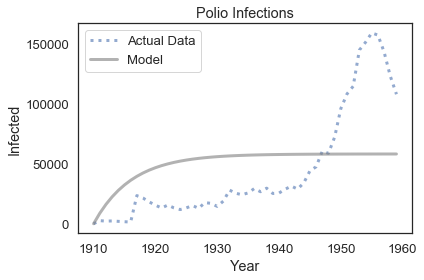

In [125]:
# Run the simulation (transpose the results so the index is first column, not first row)
results = run_simulation(system, update_func2).T
# Plot the results
plot_results(results.actual_infected, 'Actual Data',results.model_infected,'Model', 'Polio Infections','Year','Infected')

Now, the linear spread model seems to have become worse than before, even though both were subjected to the same death rate.

# Proportional Growth

In [126]:
def update_func3(state, t, system):
    """Update function for proportional infection rate accounting for deaths 
    
    state: state object
    t: year
    system: system object
        
    returns: state object
    """
    
    # Add this year's cases to the running total, then account for deaths
    state.actual_infected += table.polios[t]
    state.actual_infected *= 0.85
    
    # Calculate the spread of polio, the resulting deaths, and who is left
    state.model_infected *= system.polio_growth
    state.p_dead_polios += state.model_infected * 0.15
    state.model_infected *= 0.85
    
    return State(model_infected=state.model_infected,actual_infected=state.actual_infected)

In [127]:
# Init state containing the above, assuming no polio infections or deaths yet
init = State(model_infected=get_first_value(table.polios), p_dead_polios=0,actual_infected=0)
system = System(polio_growth = 1.285,
                t_0 = t_0,
                t_end = t_end,
                model_infected_0 = get_first_value(table.polios),
                p_dead_polios = 0,
                init=init)

,values
polio_growth,1.285
t_0,1910
t_end,1959
model_infected_0,3043
p_dead_polios,0
init,model_infected 3043 p_dead_polios ...


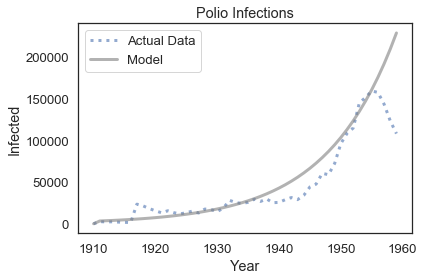

In [128]:
# Run the simulation (transpose the results so the index is first column, not first row)
results = run_simulation(system, update_func3).T
# Plot the results
plot_results(results.actual_infected, 'Actual Data',results.model_infected,'Model', 'Polio Infections','Year','Infected')

Now our model seems to follow the sample data much better.

# Introducing the Vaccine 

After some experimentation during the early 1950's, the polio vaccine was licensed and distributed on a wider scale in 1955. From 1953 to 1961, the number of reported cases dropped from 35,000 to just 161. Looking back at our input data, we see a very fast decent over this period:

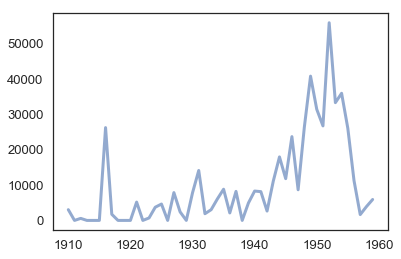

In [129]:
plot(table.polios);

One way to model the vaccine introduction is to set the growth rate to zero at a certain year. A new update function that does this is below.

In [130]:
def update_func4(state, t, system):
    """Update function for proportional infection rate accounting for deaths and vaccine introduction
    
    state: state object
    t: year
    system: system object
        
    returns: state object
    """
    
    # Add this year's cases to the running total, then account for deaths
    state.actual_infected += table.polios[t]
    state.actual_infected *= 0.85
    
    # Calculate the spread of polio, the resulting deaths, and who is left
    # Decide what the growth rate is depending on the vaccination year, which is passed in system
    # The pre and post vaccination polio spread rates are passed in system now
    if t >= system.t_vax:
        growth = system.post_vax_growth
    else:
        growth = system.polio_growth
    state.model_infected *= growth
    state.p_dead_polios += state.model_infected * 0.15
    state.model_infected *= 0.85
    
    return State(model_infected=state.model_infected,actual_infected=state.actual_infected)

In [131]:
# Init state containing the above, assuming no polio infections or deaths yet
init = State(model_infected=get_first_value(table.polios),p_dead_polios=0,actual_infected=0)
system = System(polio_growth = 1.285,
                post_vax_growth = 1.00,
                t_0 = t_0,
                t_end = t_end,
                t_vax = 1955,
                model_infected_0 = get_first_value(table.polios),
                p_dead_polios = 0,
                init=init)

,values
polio_growth,1.285
post_vax_growth,1
t_0,1910
t_end,1959
t_vax,1955
model_infected_0,3043
p_dead_polios,0
init,model_infected 3043 p_dead_polios ...


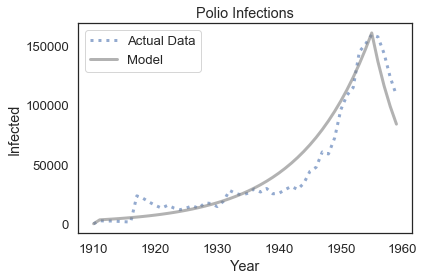

In [132]:
# Run the simulation (transpose the results so the index is first column, not first row)
results = run_simulation(system, update_func4).T
# Plot the results
plot_results(results.actual_infected, 'Actual Data',results.model_infected,'Model', 'Polio Infections','Year','Infected')

# Counting Deaths
To answer the original question, we must record the number of people who are dying year by year. This update function does that

In [150]:
def update_func5(state, t, system):
    """Update function for proportional infection rate accounting for deaths and vaccine introduction
    
    state: state object
    t: year
    system: system object
        
    returns: state object of actual infected, model infected, and deaths
    """
    
    # Add this year's cases to the running total, then account for deaths
    #state.actual_infected += table.polios[t]
    #state.actual_infected *= 0.85
    
    # Calculate the spread of polio, the resulting deaths, and who is left
    # Decide what the growth rate is depending on the vaccination year, which is passed in system
    # The pre and post vaccination polio spread rates are passed in system now
    if t >= system.t_vax:
        growth = system.post_vax_growth
    else:
        growth = system.polio_growth
    state.model_infected *= growth
    state.polio_deaths += state.model_infected * 0.15
    state.model_infected *= 0.85
    
    return State(model_infected=state.model_infected,actual_infected=state.actual_infected,polio_deaths=state.polio_deaths)

In [153]:
# Init state containing the above, assuming no polio infections or deaths yet
init = State(model_infected=get_first_value(table.polios),polio_deaths=0,actual_infected=0)
system = System(polio_growth = 1.285,
                post_vax_growth = 1.00,
                t_0 = t_0,
                t_end = 1990,
                t_vax = 1955,
                model_infected_0 = get_first_value(table.polios),
                polio_deaths = 0,
                init=init)

,values
polio_growth,1.285
post_vax_growth,1
t_0,1910
t_end,1990
t_vax,1955
model_infected_0,3043
polio_deaths,0
init,model_infected 3043 polio_deaths ...


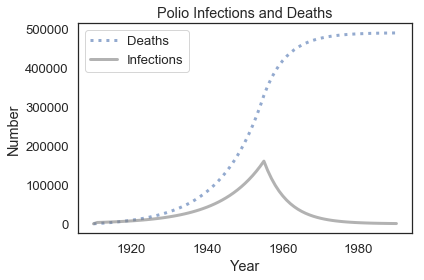

In [154]:
# Run the simulation (transpose the results so the index is first column, not first row)
results = run_simulation(system, update_func5).T
# Plot the results
plot_results(results.polio_deaths, 'Deaths',results.model_infected,'Infections', 'Polio Infections and Deaths','Year','Number')